# Seismic Geometry tutorial: part 2

In the [**first part**](./01_Geometry_part_1) of the `SeismicGeometry` tutorial you found out of methods and properties which helps to **examine the geology**.

This notebook is the second part of the `SeismicGeometry` tutorial which shows methods that help to **work with seismic data**, specifically:

* [Optimizing seismic data loading](#formats)
* [Saving processed data](#saving)

In [1]:
# All the necessary imports
import os
import sys
import numpy as np
from time import perf_counter
from matplotlib import pyplot as plt

sys.path.append('..')
from seismiqb import SeismicGeometry, plot_image

In [2]:
%%time
geometry = SeismicGeometry(path='/data/seismic_data/seismic_interpretation/001_YETYPUR/001_YETYPUR.sgy',
                           collect_stats=True, spatial=True, recollect=True, pbar='t')

print(geometry)

Finding min/max: 100%|█████████████| 3611267/3611267 [01:22<00:00, 43932.13it/s]



Processed geometry for cube    /data/seismic_data/seismic_interpretation/001_YETYPUR/001_YETYPUR.sgy
Current index:                 ['INLINE_3D', 'CROSSLINE_3D']
Cube shape:                    (2563, 1409, 1501)
Time delay:                    50
Sample rate:                   2.0
Area:                          1522.4 km²

SEG-Y original size:           21.000 GB
Current cube size:             21.000 GB
Size of the instance:          1.106 GB

Number of traces:              3611267
Number of non-zero traces:     2435820
Fullness:                      0.67

Original cube values:
Number of uniques:                    192
mean | std:                          0.12 | 1887.29   
min | max:                      -47429.45 | 39240.19  
q01 | q99:                       -5459.50 | 5118.29   

CPU times: user 6min 5s, sys: 19.6 s, total: 6min 24s
Wall time: 6min 6s


<a id='formats'></a>
# Optimizing seismic data loading

**SEG-Y** format is, essentially, a 2D container of traces. That is not very efficient for slide loading, and we can reshape and rewrite this array into an actual 3D cube of values. As we keep the meta information about the cube right next to it in a `CUBE_NAME.meta` file, so all of the optimized storages need only to keep the array itself.

***By default, a cube in another format is stored right next to its SEG-Y counterpart.***

***Creating a 3D volume requires a strict and clear spatial structure, so converting is restricted to `INLINE_3D`/`CROSSLINE_3D` indexing headers.***

As alternatives to the **SEG-Y** format, we have **HDF5**, **BLOSC**, **QHDF5**, and **QBLOSC** formats. 

**BLOSC** and **HDF5** are more recent and optimized approaches to data storage than **SEG-Y**:

 * [**HDF5**](https://www.hdfgroup.org/solutions/hdf5/) is designed to store and organize large amounts of data.

 * [**BLOSC**](https://www.blosc.org/pages/blosc-in-depth/) provides a way to compress binary data, allowing the memory fetch approach. This format helps to save storage space and reduce memory access time.

**QBLOSC** and **QHDF5** are compressed versions of corresponding formats: **Q** means quantization. **Quantization** is a conversion process **float** values to **int8** using cube statistics: we need less storage space but loose data accuracy.

Let's compare data formats from a speed and storage efficiency points of view:

In [3]:
geometry_hdf5 = geometry.convert_to_hdf5(quantize=False, store_meta=False, pbar='t')
geometry_qhdf5 = geometry.convert_to_hdf5(store_meta=False, pbar='t')
geometry_blosc = geometry.convert_to_blosc(quantize=False, store_meta=False, pbar='t')
geometry_qblosc = geometry.convert_to_blosc(store_meta=False, pbar='t')

names = ["SEG-Y", "HDF5", "QHDF5", "BLOSC", "QBLOSC"]
geometries = [geometry, geometry_hdf5, geometry_qhdf5, geometry_blosc, geometry_qblosc]

Creating 001_YETYPUR.hdf5; h-projection: 100%|█| 5473/5473 [08:41<00:00, 10.50it
Creating 001_YETYPUR.qhdf5; h-projection: 100%|█| 5473/5473 [15:14<00:00,  5.98i
Creating 001_YETYPUR.blosc; h-projection: 100%|█| 5473/5473 [12:54<00:00,  7.07i
Creating 001_YETYPUR.qblosc; h-projection: 100%|█| 5473/5473 [17:57<00:00,  5.08


In [4]:
timings = {}
sizes = {}

for geometry, name in zip(geometries, names):
    timings[name] = geometry.benchmark()
    sizes[name] = os.path.getsize(geometry.path) / (1024**3)

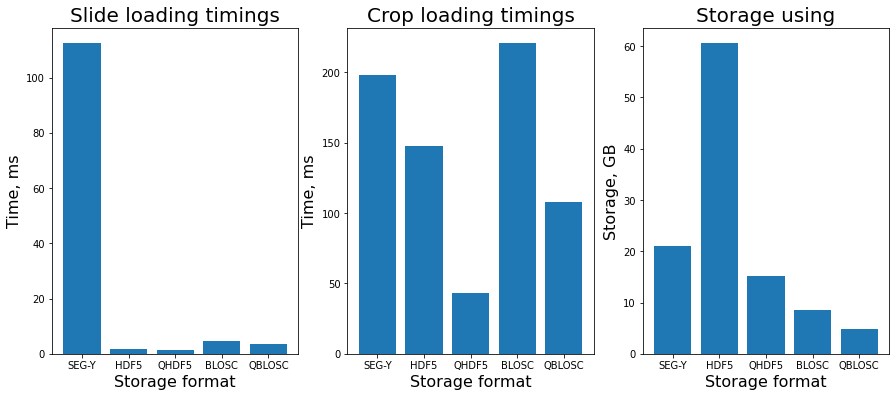

In [5]:
def plot_ax(dct, unit, title, ax):
    bars = ax.bar(dct.keys(), dct.values())
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Storage format', fontsize=16)
    ax.set_ylabel(unit, fontsize=16)
    return ax

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0] = plot_ax({key: value['slide']['wall'] for key, value in timings.items()},
                 "Time, ms", "Slide loading timings", axs[0])
axs[1] = plot_ax({key: value['crop']['wall'] for key, value in timings.items()},
                 "Time, ms", "Crop loading timings", axs[1])
axs[2] = plot_ax(sizes, "Storage, GB", "Storage using", axs[2])
plt.show()

Note the bigger cube size in **HDF5** format: it is almost 3 times the size of the original **SEG-Y** cube! That is because we store not only the `(iline, crossline, depth)` projection but also the `(crossline, depth, iline)` and `(depth, iline, crossline)` ones: that is done to make slide loading along all the dimensions as fast as possible. As we can see, the converted version is much faster. For creating a **BLOSC** file, we do the same.

**BLOSC** needs much less storage than **SEG-Y** and **HDF5** and loads slides faster than **SEG-Y**. 

So we have that:
 * **QBLOSC** is more efficient in terms of data storage;
 * **QHDF5** provides the best load data timings.

***The entire functionality is the same for all formats:***

Straightforward quality estimation of the seismic data can be done by looking at the signal-to-noise ratio for each of the traces: in our case, it is defined as:
$$ log_{10} \frac{E(trace)^2}{Var(trace)^2}$$

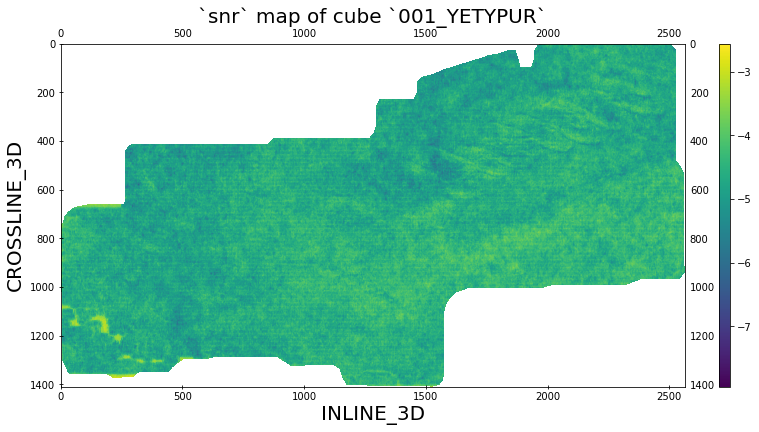

In [6]:
geometry_qhdf5.show(matrix='snr', cmap='viridis')

Obviously, all of the previous visualization functions are still available.

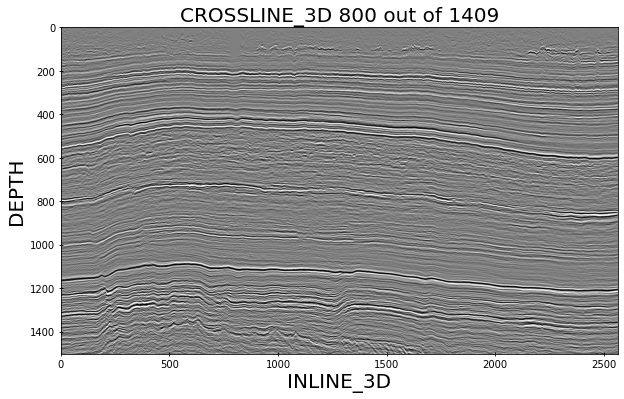

In [7]:
geometry.show_slide(loc=800, axis=1, figsize=(12, 6))

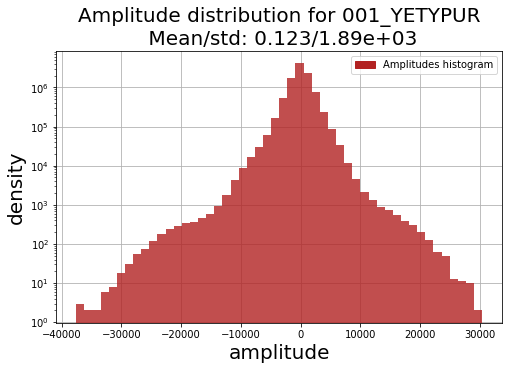

In [8]:
geometry_qhdf5.show_histogram(hist_log=True)

<a id='saving'></a>
# Saving processed data

When all work with a cube is done, we can easily save results.
For example, we have an array with a processed cube and want to dump it into memory as a new **SEG-Y** cube:

In [9]:
from seismiqb.src.geometry import export
!rm processed.*

# Some results, e.g. cube after manipulations
processed_data = geometry[1000:2000, 500:1000, :] * 2
processed_data = processed_data.copy()

export.make_segy_from_array(array=processed_data.copy(), sample_rate=2.0, delay=50,
                            path_segy='processed.sgy', zip_segy=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's check processed cube:

In [10]:
geometry_processed_sgy = SeismicGeometry(path='processed.sgy', process_stats=False, pbar='t')

loc = np.random.randint(geometry_processed_sgy.cube_shape[0])

geometry_slide = geometry_processed_sgy.load_slide(loc=loc)
data_slide = processed_data[loc]

print(f"Check a random slide: {np.all(geometry_slide==data_slide)}")
print(f"Check the entire cube: {np.all(geometry_processed_sgy[:, :, :].ravel()==processed_data.ravel())}")

Finding min/max: 100%|███████████████| 500000/500000 [00:11<00:00, 43188.33it/s]


Check a random slide: True
Check the entire cube: True


# Conclusion

This concludes the `SeismicGeometry` tutorial: now you know how to work with various cubes with the help of our framework. To sum up, you have learned how to:

- infer geological properties like SNR of seismic cubes
- load actual slices of seismic data, as well as visualize them
- convert SEGY-cubes into HDF5, BLOSC, QHDF5, QBLOSC-formats for faster data loading
- display simple amplitude distribution statistics
- save processed cubes

The [next tutorial](./01_Horizon.ipynb) shows how to add 2D surfaces, also known as horizons, to the cubes.